In [40]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [41]:
dataset_path = "../Datasets/WineQT.csv"

random_state = 42
wandb_log = False

In [42]:
lr = 0.001
max_epochs = 10000
optimizer = 'bgd'
activation = 'sigmoid'
hidden_layers = [8,]
batch_size = 32

In [43]:
if wandb_log:
    config = {
        "lr": lr, 
        "model_type": "MLP_Classifier",
        "optimizer": optimizer, # SGC/BGD/MBGD
        "criterion": "mse",
        "num_epochs": max_epochs,
        "batch_size": batch_size,
        "hidden_layers": hidden_layers,
        "activation": activation,
        # "gpu_id": 0,
        "wandb_run_name": "bhav" ,
        "tags": ["P3",]
    }

    wandb.init(entity = "bhavberi",   # wandb username. (NOT REQUIRED ARG. ANYMORE, it fetches from initial login)
            project = "SMAI",        # wandb project name. New project will be created if given project is missing.
            config = config         # Config dict
            )
    wandb.run.name = f"{config['optimizer']}_{config['activation']}_{len(config['hidden_layers'])}_{config['lr']}_{config['batch_size']}_{config['num_epochs']}"
    print(wandb.run.name)

In [44]:
dataset = pd.read_csv(dataset_path)
print(dataset.columns)
dataset.drop(['Id'], axis=1, inplace=True)
dataset.head()

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'Id'],
      dtype='object')


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [45]:
print(dataset.isna().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [46]:
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [47]:
X = dataset.drop(columns=['quality']).to_numpy()
y = dataset['quality'].to_numpy()

num_classes = 11 # 0-10

In [48]:
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
# To fill in data

In [49]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_validation.shape, y_validation.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (914, 11) (914,)
Validation set shape: (114, 11) (114,)
Test set shape: (115, 11) (115,)


In [50]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_validation_std = scaler.transform(X_validation)
X_test_std = scaler.transform(X_test)

In [57]:
class MLP_Classifier:
    def __init__(self, input_size, hidden_layers, num_classes=10, learning_rate=0.01, activation='sigmoid', optimizer='sgd'):
        assert activation.lower() in ['sigmoid', 'relu', 'tanh'], "Activation function must be either 'sigmoid', 'relu' or 'tanh'"
        assert optimizer.lower() in ['sgd', 'bgd', 'mbgd'], "Optimizer must be either 'sgd', 'bgd' or 'mbgd'"
        assert input_size > 0, "Input size must be greater than 0"
        assert num_classes > 0, "Output size must be greater than 0"
        assert learning_rate > 0, "Learning rate must be greater than 0"
        assert type(hidden_layers) == list and len(hidden_layers) > 0, "Hidden layers must be a list of size greater than 0"

        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = num_classes
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.activation_func = self._get_activation_func(activation)
        self.optimizer_func = self._get_optimizer_func(optimizer)
        self.weights, self.biases = self._initialize_weights_and_biases()
    
    # Activation functions
    def _get_activation_func(self, activation):
        if activation == 'sigmoid':
            return self._sigmoid
        elif activation == 'tanh':
            return self._tanh
        elif activation == 'relu':
            return self._relu
        else:
            raise ValueError(f"Activation function '{activation}' not supported.")

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _tanh(self, x):
        return np.tanh(x)

    def _relu(self, x):
        return np.maximum(0, x)
    
    # Activation derivative
    def _activation_derivative(self, Z):
        if self.activation_func == self._sigmoid:
            return self._sigmoid_derivative(Z)
        elif self.activation_func == self._tanh:
            return self._tanh_derivative(Z)
        elif self.activation_func == self._relu:
            return self._relu_derivative(Z)
        else:
            raise ValueError(f"Activation function '{self.activation_func}' not supported.")
    
    def _sigmoid_derivative(self, Z):
        return self._sigmoid(Z) * (1 - self._sigmoid(Z))
    
    def _tanh_derivative(self, Z):
        return 1 - np.square(self._tanh(Z))
    
    def _relu_derivative(self, Z):
        return np.where(Z > 0, 1, 0)
    
    # Optimizers
    def _get_optimizer_func(self, optimizer):
        if optimizer == 'sgd':
            return self._sgd
        elif optimizer == 'bgd':
            return self._bgd
        elif optimizer == 'mbgd':
            return self._mbgd
        else:
            raise ValueError(f"Optimizer '{optimizer}' not supported.")
    
    def _sgd(self, grads):
        for i in range(len(self.weights)):
            # print(self.biases[i].shape, grads['db'][i].shape)
            self.weights[i] -= self.learning_rate * grads['dW'][i]
            self.biases[i] -= self.learning_rate * grads['db'][i]
    
    def _bgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads['dW'][i] / self.input_size
            self.biases[i] -= self.learning_rate * grads['db'][i] / self.input_size
    
    def _mbgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads['dW'][i] / grads['dW'][i].shape[1]
            self.biases[i] -= self.learning_rate * grads['db'][i] / grads['db'][i].shape[1]
    
    # Initialize weights and biases
    def _initialize_weights_and_biases(self):
        num_layers = len(self.hidden_layers)
        weights = []
        biases = []
        
        # Using Github Copilot
        for i in range(num_layers + 1):
            if i == 0:
                w = np.random.randn(self.input_size, self.hidden_layers[0])
            elif i == num_layers:
                w = np.random.randn(self.hidden_layers[-1], self.output_size)
            else:
                w = np.random.randn(self.hidden_layers[i - 1], self.hidden_layers[i])
            
            b = np.zeros((1, w.shape[1]))
            weights.append(w)
            biases.append(b)

        return weights, biases
    
    # Forward propagation
    def _forward_propagation(self, X):
        num_layers = len(self.weights)
        A = X
        caches = []
        
        for i in range(num_layers):
            W = self.weights[i]
            b = self.biases[i]
            
            Z = np.dot(A, W) + b
            A = self.activation_func(Z)
            
            if Z.shape[1] == 1:
                Z = Z.reshape(-1)
            caches.append((A, W, b, Z))
            # print(A.shape, W.shape, b.shape, Z.shape)
        
        if A.shape[1] == 1:
            A = A.reshape(-1)
        return A, caches

    # Backward propagation
    def _backward_propagation(self, A, Y, caches):
        num_samples = A.shape[0]
        num_layers = len(self.weights)
        grads = {'dW': [], 'db': []}

        delta = ((A.T - Y) / num_samples).T
        # print(delta.shape, A.shape, Y.shape)

        for i in reversed(range(num_layers)):
            A, W, _, Z = caches[i]
            # print("A", A.shape, "W", W.shape, "Z", Z.shape)
            
            dZ = np.multiply(delta, self._activation_derivative(Z))
            if dZ.ndim == 1:
                dZ = dZ.reshape((dZ.shape[0], 1))
            # print("dZ", dZ.shape)
            delta = np.dot(dZ, W.T)
            dW = np.dot(A.T, delta).T
            # print("dW", dW.shape)
            db = np.sum(dZ, axis=0, keepdims=True)
            # print("db", db.shape)

            # print("delta", delta.shape)

            grads['dW'].append(dW)
            grads['db'].append(db)
        
        grads['dW'].reverse()
        grads['db'].reverse()

        return grads
    
    # Calculate cost
    def _calculate_cost(self, A, Y):
        num_samples = Y.shape[0]
        cost = np.sum(np.not_equal(A, Y)) / (num_samples * self.output_size)
        return cost

    # Predict
    def predict(self, X):
        A, _ = self._forward_propagation(X)

        # Apply a softmax to get probabilities & then getting the h9ghest probability
        A = np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)

        A = np.argmax(A,axis=1)
        return A

    # Train the model
    def train(self, X, Y, max_epochs=10, batch_size=32, X_validation=None, y_validation=None):
        num_samples = X.shape[0]
        costs = []
        
        for i in range(max_epochs):
            if self.optimizer == "bgd":
                batch_size = num_samples
                num_batches = 1
            elif self.optimizer == "sgd":
                batch_size = 1
                num_batches = num_samples
            elif self.optimizer == "mbgd":
                num_batches = num_samples // batch_size
            else:
                raise ValueError(f"Optimizer '{self.optimizer}' not supported.")
            
            for j in range(num_batches):
                start = j * batch_size
                end = start + batch_size
                
                A, caches = self._forward_propagation(X[start:end])
                grads = self._backward_propagation(A, Y[start:end], caches)
                self.optimizer_func(grads)
            
            A = self.predict(X)
            cost = self._calculate_cost(A, Y)
            costs.append(cost)

            data_to_log = {
                "epoch": i + 1,
                "train_loss": cost
            }

            # Calculate validation loss
            if X_validation is not None and y_validation is not None:
                A = self.predict(X_validation)
                val_loss = self._calculate_cost(A, y_validation)
                data_to_log["val_loss"] = val_loss

            if wandb_log:
                wandb.log(data_to_log)
            
            if (i+1) % 5 == 0:
                print(f"Cost after {i+1} epochs: {cost}")
        
        return costs

In [58]:
model = MLP_Classifier(X_train_std.shape[1], hidden_layers, num_classes, learning_rate=lr, activation=activation, optimizer=optimizer)
costs = model.train(X_train_std, y_train, max_epochs=max_epochs, batch_size=batch_size, X_validation=X_validation_std, y_validation=y_validation)

Cost after 5 epochs: 0.09041177640740004
Cost after 10 epochs: 0.09041177640740004
Cost after 15 epochs: 0.09041177640740004
Cost after 20 epochs: 0.09041177640740004
Cost after 25 epochs: 0.09041177640740004
Cost after 30 epochs: 0.09041177640740004
Cost after 35 epochs: 0.09041177640740004
Cost after 40 epochs: 0.09041177640740004
Cost after 45 epochs: 0.09041177640740004
Cost after 50 epochs: 0.09041177640740004
Cost after 55 epochs: 0.09041177640740004
Cost after 60 epochs: 0.09041177640740004
Cost after 65 epochs: 0.09041177640740004
Cost after 70 epochs: 0.09041177640740004
Cost after 75 epochs: 0.09041177640740004
Cost after 80 epochs: 0.09041177640740004
Cost after 85 epochs: 0.09041177640740004
Cost after 90 epochs: 0.09041177640740004
Cost after 95 epochs: 0.09041177640740004
Cost after 100 epochs: 0.09041177640740004
Cost after 105 epochs: 0.09041177640740004
Cost after 110 epochs: 0.09041177640740004
Cost after 115 epochs: 0.09041177640740004
Cost after 120 epochs: 0.090411

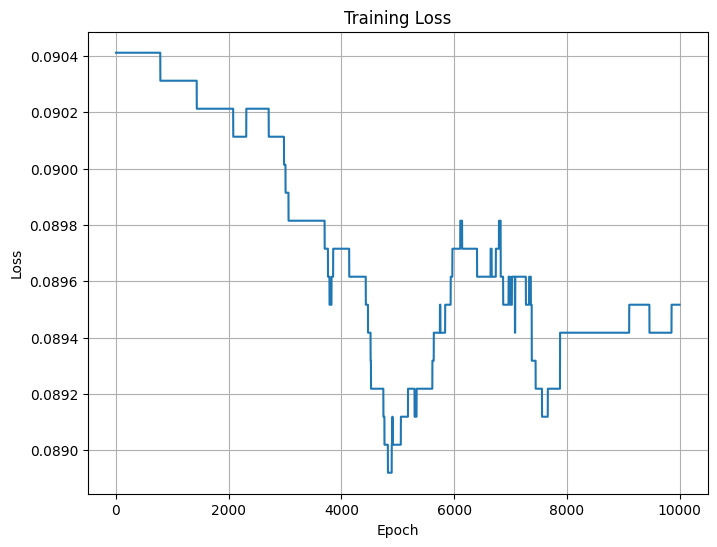

In [59]:
plt.figure(figsize=(8, 6))
plt.plot(costs)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [54]:
if wandb_log:
    wandb.finish()